In [ ]:
import os, sys

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Change directory to project root
project_path = "/content/drive/MyDrive/medical-image-cnn"
%cd $project_path

# 3. Add project root to Python path
if project_path not in sys.path:
    sys.path.append(project_path)

# 4. Ensure __init__.py files exist in src/ packages
folders = [
    "src",
    "src/classification",
    "src/segmentation",
    "src/detection"
]
for folder in folders:
    init_file = os.path.join(folder, "__init__.py")
    if not os.path.exists(init_file):
        with open(init_file, "w") as f:
            f.write("# init\n")
        print(f"Created: {init_file}")

# 5. Check structure
print("SRC contents:", os.listdir(os.path.join(project_path, "src")))


Mounted at /content/drive
/content/drive/MyDrive/medical-image-cnn
SRC contents: ['classification', 'segmentation', 'detection', 'utils.py', '__init__.py', '__pycache__']


In [ ]:
!pip install tensorflow keras matplotlib seaborn scikit-learn opencv-python


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from src.classification.data_loader import get_classification_generators
from src.classification.model_builder import build_mobilenet_classifier
from src.utils import plot_training
import numpy as np # Added numpy import

# Load Data
# Point data_dir to the root of the dataset where train, val, and test folders are located
data_dir = "/content/drive/MyDrive/medical-image-cnn/datasets/brain_mri"
img_size = (128,128)   # smaller images = faster
batch_size = 16

train_gen, val_gen, test_gen = get_classification_generators(
    data_dir=data_dir,
    img_size=img_size,
    batch_size=batch_size
)

# Get the classes from the training generator
train_classes = list(train_gen.class_indices.keys())
num_classes = len(train_classes)
print("Classes:", train_gen.class_indices)

# Filter test_gen to only include classes present in train_gen
# This assumes get_classification_generators returns a DirectoryIterator
if hasattr(test_gen, 'classes'):
    # Recreate class_indices for the test set based on available classes
    test_class_indices = {cls: i for i, cls in enumerate(sorted(list(set([test_gen.filenames[i].split('/')[0] for i in range(len(test_gen.filenames))]))))}

    test_indices = [i for i in range(len(test_gen.filenames)) if test_gen.filenames[i].split('/')[0] in train_classes]

    # Create a new generator with filtered indices
    from tensorflow.keras.utils import Sequence
    class FilteredTestDataGenerator(Sequence):
        def __init__(self, original_generator, indices, class_indices):
            self.generator = original_generator
            self.indices = indices
            self.batch_size = original_generator.batch_size
            self.class_indices = class_indices # Use the filtered class indices
            self.classes = np.array([self.class_indices[original_generator.filenames[i].split('/')[0]] for i in indices]) # Update classes attribute

        def __len__(self):
            return int(np.ceil(len(self.indices) / self.batch_size))

        def __getitem__(self, idx):
            batch_indices_in_original = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            # Get the batch using the original generator's method
            # This might require accessing protected members, adjust if necessary based on the actual generator implementation
            batch_x, batch_y_original = self.generator._get_batches_of_transformed_samples(batch_indices_in_original)

            # If original_generator yields one-hot encoded labels, convert back to integer
            if batch_y_original.ndim > 1:
                 batch_y_original = np.argmax(batch_y_original, axis=1)

            # Map original class indices to filtered class indices
            batch_y_filtered = np.array([self.class_indices[list(self.generator.class_indices.keys())[original_label]] for original_label in batch_y_original])

            # One-hot encode filtered labels if needed by the model
            # Assuming the model expects one-hot encoding
            num_filtered_classes = len(self.class_indices)
            batch_y_one_hot = np.zeros((len(batch_y_filtered), num_filtered_classes))
            batch_y_one_hot[np.arange(len(batch_y_filtered)), batch_y_filtered] = 1

            return batch_x, batch_y_one_hot


    # Create class_indices for the filtered test set
    filtered_test_class_labels = sorted(list(set([test_gen.filenames[i].split('/')[0] for i in test_indices])))
    filtered_test_class_indices = {cls: i for i, cls in enumerate(filtered_test_class_labels)}


    test_gen = FilteredTestDataGenerator(test_gen, test_indices, filtered_test_class_indices)
    print(f"Filtered test set to {len(test_indices)} images with classes from training set.")
    # Update num_classes to reflect the number of classes in the training set
    num_classes = len(train_classes)
    print(f"Number of classes for model: {num_classes}")

Found 13888 images belonging to 4 classes.
Found 3470 images belonging to 4 classes.
Found 4333 images belonging to 4 classes.
Classes: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}
Filtered test set to 4333 images with classes from training set.
Number of classes for model: 4


In [ ]:
model = build_mobilenet_classifier(input_shape=(128,128,3), num_classes=num_classes)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5744 - loss: 1.0690

200/200 ━━━━━━━━━━━━━━━━━━━━ 134s 630ms/step - accuracy: 0.5748 - loss: 1.0680 - val_accuracy: 0.7500 - val_loss: 0.6201
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7303 - loss: 0.6987

200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.7304 - loss: 0.6986 - val_accuracy: 0.7800 - val_loss: 0.5820
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7762 - loss: 0.5884

200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - accuracy: 0.7762 - loss: 0.5883 - val_accuracy: 0.7925 - val_loss: 0.5382
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7787 - loss: 0.5444

200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 417ms/step - accuracy: 0.7788 - loss: 0.5443 - val_accuracy: 0.8413 - val_loss: 0.4540
Epoch 5/10
 68/200 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.8059 - loss: 0.5264

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.8109 - loss: 0.5076 - val_accuracy: 0.7825 - val_loss: 0.5373
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 66s 206ms/step - accuracy: 0.7883 - loss: 0.5245 - val_accuracy: 0.8175 - val_loss: 0.4951
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - accuracy: 0.8047 - loss: 0.4852 - val_accuracy: 0.8200 - val_loss: 0.4661


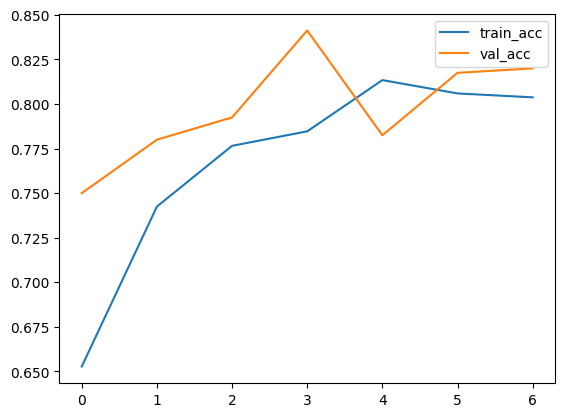

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Ensure checkpoint folder exists
os.makedirs("outputs/checkpoints", exist_ok=True)

checkpoint = ModelCheckpoint(
    "outputs/checkpoints/best_brain_mri.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,  # stop earlier if no improvement
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,              # shorter training (early_stop will handle stopping)
    steps_per_epoch=200,    # speed up each epoch
    validation_steps=50,
    callbacks=[checkpoint, early_stop]
)

plot_training(history)


271/271 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step
 Test Accuracy: 0.78

 Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.74      0.87      0.80      1260
meningioma_tumor       0.86      0.55      0.67      1278
          normal       0.87      0.73      0.79       614
 pituitary_tumor       0.73      0.95      0.82      1181

        accuracy                           0.78      4333
       macro avg       0.80      0.77      0.77      4333
    weighted avg       0.79      0.78      0.77      4333



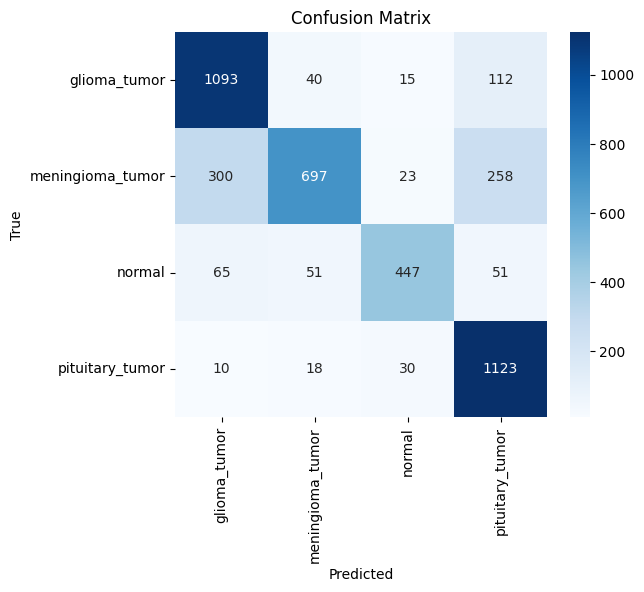

In [ ]:
# Evaluate Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions first (instead of evaluate)
y_pred = model.predict(test_gen)

# True labels from generator
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# If model was trained with categorical_crossentropy, labels must be one-hot.
# But test_gen gives integer labels -> so we use argmax on predictions only
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute test accuracy manually
test_acc = np.mean(y_pred_classes == y_true)
print(f" Test Accuracy: {test_acc:.2f}")

# Classification report
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
model.save("outputs/brain_mri_classifier.h5")
print("Model saved!")


Model saved!


Saving Screenshot 2025-09-05 235632.png to Screenshot 2025-09-05 235632.png
Uploaded: Screenshot 2025-09-05 235632.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: meningioma_tumor (65.56%)


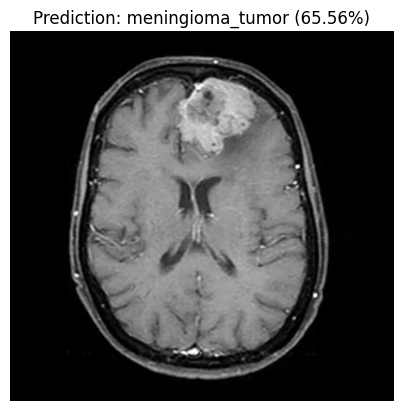

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files

# 1. Load best saved model
model = load_model("outputs/checkpoints/best_brain_mri.h5")  # use checkpoint if that's where best model is

# 2. Upload an MRI image
uploaded = files.upload()

for fname in uploaded.keys():
    print("Uploaded:", fname)

    # 3. Load and preprocess image (match training size 128x128)
    img = cv2.imread(fname)
    img_resized = cv2.resize(img, (128,128)) / 255.0  # changed from 224 to 128
    img_resized = np.expand_dims(img_resized, axis=0)  # shape (1,128,128,3)

    # 4. Predict class
    pred = model.predict(img_resized)
    class_labels = list(test_gen.class_indices.keys())  # reuse labels from generator
    pred_class = class_labels[np.argmax(pred)]
    confidence = np.max(pred) * 100

    print(f"Prediction: {pred_class} ({confidence:.2f}%)")

    # 5. Show image with prediction
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()
